<a href="https://colab.research.google.com/github/mbaroja/TFM/blob/code/AffinityPropagation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Affinity Propagation clustering**

Matriz de responsabilidad: importancia de cada punto de datos

Matriz de disponibilidad: cantidad de vecinos de cada punto

Matriz de similitud: cuanto más cercanos más similares

Ejemplares: puntos con mayor responsabilidad y disponiblidad

### Hiperparámetros
Este algoritmo no requiere determinar el número de clústeres antes de su ejecución, siendo el propio algoritmo el que encuentra el nº óptimo.

*   **damping**: factor de amortiguación que evita oscilaciones numéricas al actualizar mensajes. Rango [0.5, 1.0) a mayor damping, menos clusters
*   **affinity**: distandia euclídea (por defecto) o precalculada
*   **converge_iter**: nº de iteraciones sin cambiar el nº de clusters estimados antes de converger
*   **preference**: (none por defecto == la media de la matriz de similitud) basado en la matriz de responsablidad y disponibilidad. Recomendable muy baja, asociado al nº de clusters controla cuántos ejemplares se utilizan.
*   **max_iter**: nº máximo de iteraciones

# **Librerías**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import AffinityPropagation
from sklearn.decomposition import PCA
from sklearn import metrics
from sklearn.metrics import silhouette_score, silhouette_samples

# **Datos**
Trabajaremos con 3 ficheros previamente anonimizados y preprocesados (eliminación de filas con todos los valores nulos y relleno de vacíos según los criterios establecidos en el EDA https://github.com/mbaroja/TFM/blob/code/EDA.ipynb):

*   **df_without_avg**: Fichero base, sin medias: 133 x 86
*   **df_only_avg**: Fichero solo con medias: 133 x 29
*   **df_total**: Fichero completo: 133 x 110



In [2]:
df_total = pd.read_csv('https://raw.githubusercontent.com/mbaroja/TFM/data/data_cleaned.csv', delimiter=';')
df_only_avg = pd.read_csv("https://raw.githubusercontent.com/mbaroja/TFM/data/data_cleaned_only_avgcolumns.csv",delimiter=";")
df_without_avg = pd.read_csv("https://raw.githubusercontent.com/mbaroja/TFM/data/data_cleaned_without_avgcolumns.csv",delimiter=";")

####**Transformación**
*Aunque el algoritmo permite trabajar con datos mixtos, númericos y categóricos y pueda ocurrir que la agrupación de una variable categórica convertida en númerica no obtenga el mismo resultado, trabajaremos con datos numéricos en todos los algoritmos de clasificación no supervisada.*

In [3]:
def transformData (df):
  #identificar las columnas que contienen valores de texto en el conjunto de datos
  data_text = df.select_dtypes(include='object')
  # aplicar la codificación one-hot utilizando el método get_dummies de Pandas para convertir esas columnas en columnas numéricas
  data_encoded = pd.get_dummies(data_text)
  #una vez que preprocesados los datos, combinar las columnas numéricas procesadas con el resto del conjunto de datos.
  data_numeric = df.select_dtypes(exclude='object')
  data_processed = pd.concat([data_numeric, data_encoded], axis=1)
  return data_processed

# *Métodos para visualización*

> **Plot resultado: nº de clusters estimados**

In [4]:
def plot_num_cluster (X, n_clusters_, labels, cluster_centers_indices):

  plt.close("all")
  plt.figure(1)
  plt.clf()

  colors = plt.cycler("color", plt.cm.viridis(np.linspace(0, 1, 4)))

  for k, col in zip(range(n_clusters_), colors):
      class_members = labels == k
      cluster_center = X[cluster_centers_indices[k]]
      plt.scatter(X[class_members, 0], X[class_members, 1], color=col["color"], marker=".")
      plt.scatter(cluster_center[0], cluster_center[1], s=14, color=col["color"], marker="o")
      for x in X[class_members]:
          plt.plot([cluster_center[0], x[0]], [cluster_center[1], x[1]], color=col["color"])

  plt.title("Estimated number of clusters: %d" % n_clusters_)
  plt.show()

> **Plot: Silhouette score según *preference***


In [5]:
def plot_sil_pref (ap_results, pref):
  fig, ax = plt.subplots(figsize=(8,3))
  ax = sns.lineplot(ap_results, x='preference', y='sil_score', markers=True, dashes=False, hue='clusters')
  ax.set_xlabel("Preference")
  ax.set_ylabel("Silhouette score")
  ax.axvline(pref, ls="--", c="red")
  plt.grid()
  plt.show()

> **Heatmap de características**

In [6]:
def heatMap (data_processed, labels, n_clusters_):
  # Agregar las etiquetas de clúster a los datos procesados
  data_processed['Cluster'] = labels

  # Crear el heatmap
  sns.heatmap(data_processed.T, cmap='coolwarm', cbar=False)
  plt.title('Clustered Data Heatmap n_clusters=%d' % n_clusters_)
  plt.show()

> **Gráfico de dispersión**

In [7]:
def plot_dispersion(X, labels):

  # Aplicar PCA para reducir a 2 dimensiones
  pca = PCA(n_components=2)
  X_pca = pca.fit_transform(X)

  # X_pca[:, 0] son los valores en el eje x
  # X_pca[:, 1] son los valores en el eje y
  # labels son las etiquetas de los grupos

  # Crea el gráfico de dispersión con colores según las etiquetas
  plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels)
  # Crea una leyenda o mapa de colores
  plt.colorbar()
  # Muestra el gráfico
  plt.show()

> **Gráfico de dispersión con etiquetas**

In [8]:
def plot_dispersion_etiquetas (X, labels):

  # Aplicar PCA para reducir a 2 dimensiones
  pca = PCA(n_components=2)
  X_pca = pca.fit_transform(X)

  # X_pca[:, 0] son los valores en el eje x
  # X_pca[:, 1] son los valores en el eje y
  # labels son las etiquetas de los grupos

  # Crea el gráfico de dispersión con colores según las etiquetas
  plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels)
  # Crea una leyenda o mapa de colores
  plt.colorbar()
  # Etiqueta cada punto con el índice de la fila correspondiente
  for i, label in enumerate(labels):
      plt.annotate(i, (X_pca[i, 0], X_pca[i, 1]))
  # Muestra el gráfico
  plt.show()

> **Listar atributos por cluster**


In [9]:
def list_atributos_porCluster (data_processed, n_clusters_, labels):
  # Aplicar PCA al conjunto de datos
  pca = PCA()
  pca.fit(data_processed)

  # Obtener las componentes principales y su varianza explicada
  components = pca.components_
  explained_variance = pca.explained_variance_ratio_

  # Obtener los índices de los atributos más importantes para cada clúster
  important_attributes = []
  for cluster in range(n_clusters_):
      cluster_indices = np.where(labels == cluster)[0]
      cluster_data = data_processed.iloc[cluster_indices]
      cluster_scores = np.mean(cluster_data.dot(components.T), axis=0)
      important_attributes.append(np.argsort(-np.abs(cluster_scores)))

  # Nombres de los campos
  column_names = data_processed.columns.tolist()

  # Imprimir los atributos más importantes por clúster
  for cluster, attributes in enumerate(important_attributes):
      print(f"Cluster {cluster+1}:")
      for attribute in attributes[:5]:  # Mostrar los 5 atributos más importantes
          attribute_name = column_names[attribute]
          attribute_mean = np.mean(data_processed.iloc[np.where(labels == cluster)[0], attribute])
          print(f"- Atributo n. {attribute+1}: {attribute_name} (Media: {attribute_mean})")

> **Listar índice de silueta media por cluster**

In [10]:
def list_silhoutte_porCluster(data_processed, labels):
  # Calcular el índice de silueta para cada muestra
  silhouette_values = silhouette_samples(data_processed, labels)
  # Calcular el índice de silueta individual promedio para cada clúster
  cluster_indices = sorted(set(labels))
  for cluster_idx in cluster_indices:
      # Obtener las muestras pertenecientes al clúster actual
      cluster_samples = silhouette_values[labels == cluster_idx]
      cluster_avg_silhouette = cluster_samples.mean()
      print(f"Índice de Silueta del Clúster {cluster_idx}: {cluster_avg_silhouette}")

# **Affinity Propagation: euclídea**





### **Evaluación del modelo según la preferencia**
Para encontrar el valor del parámetro *preference* asociado al nº de clústeres estimados, lo calculamos a partir de la métrica **Coeficiente de Silhoutte** que mide la compactación y separación de los grupos. Cuanto más alto sea el coeficiente, más similares son entre sí los datos agrupados.

Ejecutamos el algoritmo con un rango *preference* entre -20000 y -50 iternado de 50 en 50.

In [11]:
def eval_preferences(X):
  preferences_range = range(-20000, -50, 50)
  preferences = []
  num_clusters = []
  sil_score = []

  for p in preferences_range:
    ap = AffinityPropagation(preference = p, max_iter=200, damping=0.70).fit(X)
    cluster_centers_indices = ap.cluster_centers_indices_
    n_clusters_ = len(cluster_centers_indices)
    if n_clusters_ > 1:
      preferences.append(p)
      num_clusters.append(n_clusters_)
      sil_score.append(metrics.silhouette_score(X, ap.labels_))

  ap_results = pd.DataFrame([preferences, num_clusters, sil_score], index=['preference', 'clusters', 'sil_score']).T
  return ap_results

### **1.1 Fichero completo**

In [12]:
#Transformar datos categóricos a númericos
data_processed = transformData(df_total)
#Crear una matriz de características (feature matrix) a partir de los datos y sus columnas
X, y = data_processed.values, data_processed.columns

> **Ejecución del algoritmo con valores por defecto**

In [ ]:
#Ejecución del algoritmo con valores por defecto
ap = AffinityPropagation()
model = ap.fit(X)
cluster_centers_indices = model.cluster_centers_indices_
n_clusters_ = len(cluster_centers_indices)
labels = model.predict(X)

In [ ]:
#Visualizar resultado relación de atributos según el nº de clústeres estimados
plot_num_cluster (X, n_clusters_, labels, cluster_centers_indices)

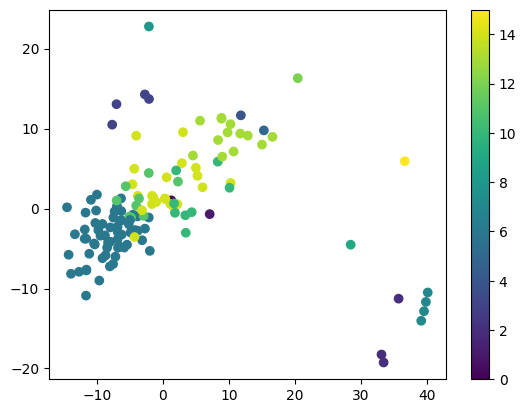

In [ ]:
#Visualizar gráfica de dispersión por clúster
plot_dispersion(X, labels)

In [ ]:
print('Estimated number of clusters: %d' % n_clusters_)
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X, labels, metric='sqeuclidean'))

Estimated number of clusters: 16
Silhouette Coefficient: 0.210


> **Obtener el valor apropiado para 'preferences' a partir del mejor coeficiente Silhoutte obtenido**

In [ ]:
#Obtener el valor apropiado para 'preferences' a partir del mejor coeficiente Silhoutte obtenido
ap_results = eval_preferences(X)
ap_results.sort_values(by='sil_score', ascending=False).head(5)

,preference,clusters,sil_score
155,-7850.0,2.0,0.555385
69,-12150.0,2.0,0.555385
80,-11600.0,2.0,0.555385
79,-11650.0,2.0,0.555385
78,-11700.0,2.0,0.555385


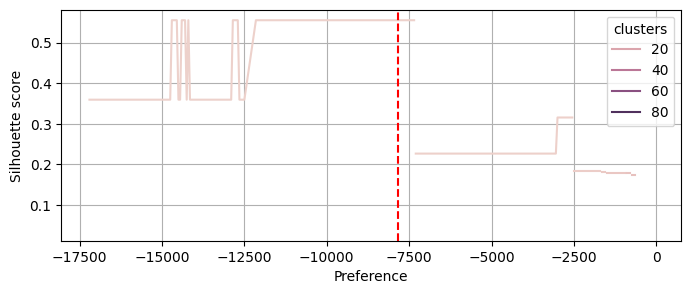

In [ ]:
#Visualizar la evolución de los valores del coeficiente Silhoutte
plot_sil_pref(ap_results, -7850)

In [ ]:
#Ejecución del algoritmo con los parámetros que obtienen un mejor coeficiente Silhoutte
ap = AffinityPropagation(damping=0.70, preference=-7850, max_iter=200)
model = ap.fit(X)
cluster_centers_indices = model.cluster_centers_indices_
n_clusters_ = len(cluster_centers_indices)
labels = model.predict(X)

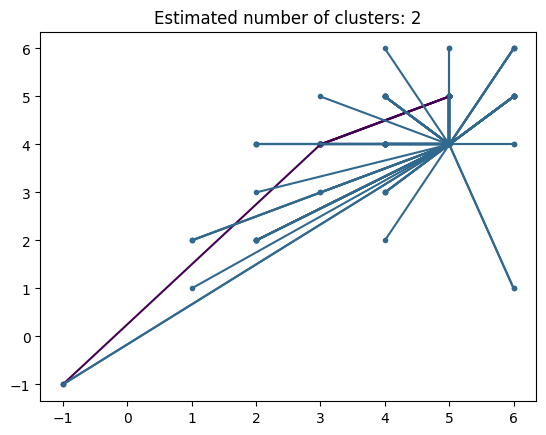

In [ ]:
#Visualizar resultado relación de atributos según el nº de clústeres estimados
plot_num_cluster (X, n_clusters_, labels, cluster_centers_indices)

In [ ]:
print('Estimated number of clusters: %d' % n_clusters_)
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X, labels, metric='sqeuclidean'))

Estimated number of clusters: 2
Silhouette Coefficient: 0.775


In [ ]:
#Visualizar mapa de calor por atributos
heatMap (data_processed, labels, n_clusters_)

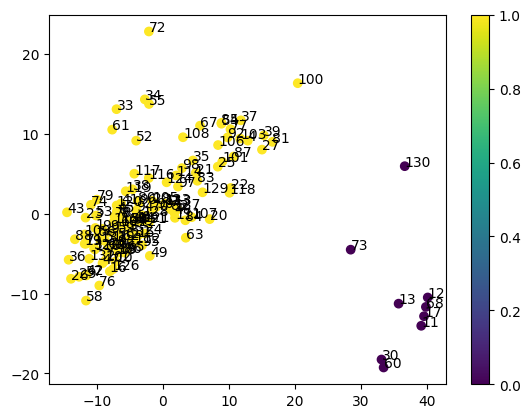

In [ ]:
#Visualizar gráfica de dispersión con la relación de atributos por clúster
plot_dispersion_etiquetas (X, labels, n_clusters_)

In [ ]:
#Listar la relación de los atributos más implicados para ser asociados a ese clúster
list_atributos_porCluster (data_processed, n_clusters_, labels)

In [ ]:
#Listar el valor medio del coeficiente Silhoutte por cluster
list_silhoutte_porCluster(data_processed, labels)

Índice de Silueta del Clúster 0: 0.5300621643408824
Índice de Silueta del Clúster 1: 0.5572224596148804


In [ ]:
# Agregar las etiquetas al DataFrame original
data_processed['Cluster'] = labels
data_processed.head()

### **1.2 Fichero solo medias**

In [ ]:
#Transformar datos categóricos a númericos
data_processed2 = transformData(df_only_avg)
#Crear una matriz de características (feature matrix) a partir de los datos y sus columnas
X2, y2 = data_processed2.values, data_processed2.columns

> **Ejecución del algoritmo con valores por defecto**

In [ ]:
#Ejecución del algoritmo con valores por defecto
ap = AffinityPropagation()
model = ap.fit(X2)
cluster_centers_indices = model.cluster_centers_indices_
n_clusters_ = len(cluster_centers_indices)
labels = model.predict(X2)

In [ ]:
#Visualizar resultado relación de atributos según el nº de clústeres estimados
plot_num_cluster (X, n_clusters_, labels, cluster_centers_indices)

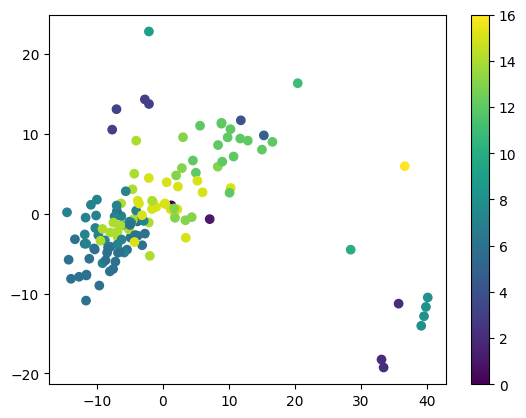

In [ ]:
#Visualizar gráfica de dispersión por clúster
plot_dispersion(X, labels)

In [ ]:
print('Estimated number of clusters: %d' % n_clusters_)
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X, labels, metric='sqeuclidean'))

Estimated number of clusters: 17
Silhouette Coefficient: 0.118


> **Obtener el valor apropiado para 'preferences' a partir del mejor coeficiente Silhoutte obtenido**

In [ ]:
#Obtener el valor apropiado para 'preferences' a partir del mejor coeficiente Silhoutte obtenido
ap_results2 = eval_preferences(X2)
ap_results2.sort_values(by='sil_score', ascending=False).head(5)

,preference,clusters,sil_score
33,-1750.0,2.0,0.576363
31,-1850.0,2.0,0.576363
16,-2600.0,2.0,0.576363
25,-2150.0,2.0,0.576363
26,-2100.0,2.0,0.576363


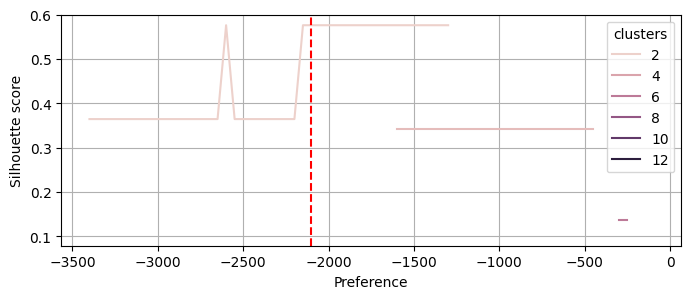

In [ ]:
#Visualizar la evolución de los valores del coeficiente Silhoutte
plot_sil_pref(ap_results2, -2100)

In [ ]:
#Ejecución del algoritmo con los parámetros que obtienen un mejor coeficiente Silhoutte
ap2 = AffinityPropagation(damping=0.70, preference=-2100, max_iter=200)
model2 = ap2.fit(X2)
cluster_centers_indices2 = model2.cluster_centers_indices_
n2_clusters_ = len(cluster_centers_indices2)
labels2 = model2.predict(X2)

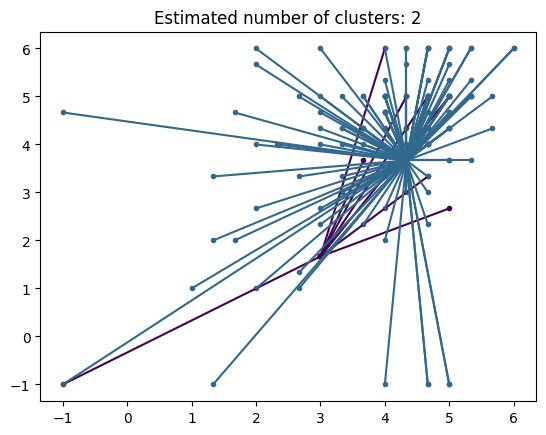

In [ ]:
#Visualizar resultado relación de atributos según el nº de clústeres estimados
plot_num_cluster (X2, n2_clusters_, labels2, cluster_centers_indices2)

In [ ]:
print('Estimated number of clusters: %d' % n2_clusters_)
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X2, labels2, metric='sqeuclidean'))

Estimated number of clusters: 2
Silhouette Coefficient: 0.790


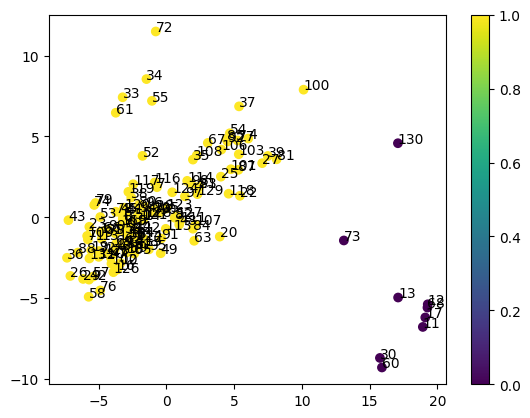

In [ ]:
#Visualizar gráfica de dispersión con la relación de atributos por clúster
plot_dispersion_etiquetas (X2, labels2)

In [ ]:
#Listar la relación de lso atributos más implicados para ser asociados a ese clúster
list_atributos_porCluster (data_processed2, n2_clusters_, labels2)

Cluster 1:
- Atributo n. 2: SA_media (Media: 3.481481481481481)
- Atributo n. 4: SP_media (Media: 2.814814814814815)
- Atributo n. 11: CJ_media (Media: -0.07407407407407411)
- Atributo n. 14: LS_media (Media: -1.0)
- Atributo n. 9: CB_media (Media: 1.8888888888888888)
Cluster 2:
- Atributo n. 1: V_media (Media: 4.021505376344086)
- Atributo n. 4: SP_media (Media: 2.4260752688172036)
- Atributo n. 2: SA_media (Media: 4.129032258064516)
- Atributo n. 3: SI_media (Media: 4.064516129032258)
- Atributo n. 11: CJ_media (Media: 2.927419354838709)


In [ ]:
#Listar el valor medio del coeficiente Silhoutte por cluster
list_silhoutte_porCluster(data_processed2, labels2)

Índice de Silueta del Clúster 0: 0.5068930741416684
Índice de Silueta del Clúster 1: 0.5814054695993428


### **1.3 Fichero sin medias**

In [ ]:
#Transformar datos categóricos a númericos
data_processed3 = transformData(df_without_avg)
#Crear una matriz de características (feature matrix) a partir de los datos y sus columnas
X3, y3 = data_processed3.values, data_processed3.columns

> **Ejecución del algoritmo con valores por defecto**

In [ ]:
#Ejecución del algoritmo con valores por defecto
ap = AffinityPropagation()
model = ap.fit(X2)
cluster_centers_indices = model.cluster_centers_indices_
n_clusters_ = len(cluster_centers_indices)
labels = model.predict(X2)

In [ ]:
#Visualizar resultado relación de atributos según el nº de clústeres estimados
plot_num_cluster (X, n_clusters_, labels, cluster_centers_indices)

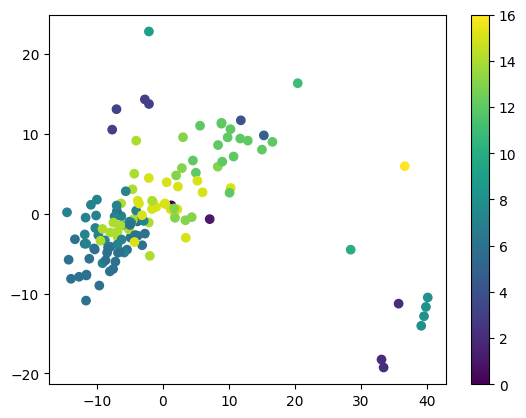

In [ ]:
#Visualizar gráfica de dispersión por clúster
plot_dispersion(X, labels)

In [ ]:
print('Estimated number of clusters: %d' % n_clusters_)
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X, labels, metric='sqeuclidean'))

Estimated number of clusters: 17
Silhouette Coefficient: 0.118


> **Obtener el valor apropiado para 'preferences' a partir del mejor coeficiente Silhoutte obtenido**

In [ ]:
#Obtener el valor apropiado para 'preferences' a partir del mejor coeficiente Silhoutte obtenido
ap_results3 = eval_preferences(X3)
ap_results3.sort_values(by='sil_score', ascending=False).head(5)

,preference,clusters,sil_score
126,-6350.0,2.0,0.546462
101,-7600.0,2.0,0.546462
85,-8400.0,2.0,0.546462
86,-8350.0,2.0,0.546462
87,-8300.0,2.0,0.546462


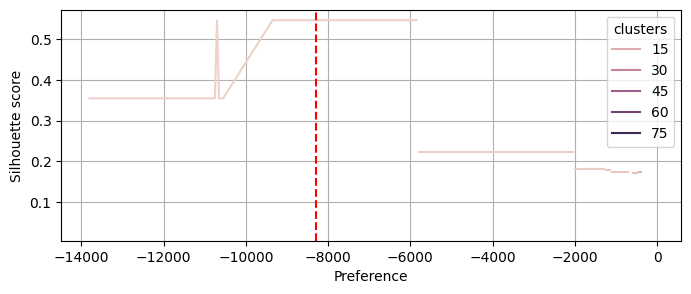

In [ ]:
#Visualizar la evolución de los valores del coeficiente Silhoutte
plot_sil_pref(ap_results3, -8300)

In [ ]:
#Ejecución del algoritmo con los parámetros que obtienen un mejor coeficiente Silhoutte
ap3 = AffinityPropagation(damping=0.70, preference=-8300, max_iter=200)
model3 = ap3.fit(X3)
cluster_centers_indices3 = model3.cluster_centers_indices_
n3_clusters_ = len(cluster_centers_indices3)
labels3 = model3.predict(X3)

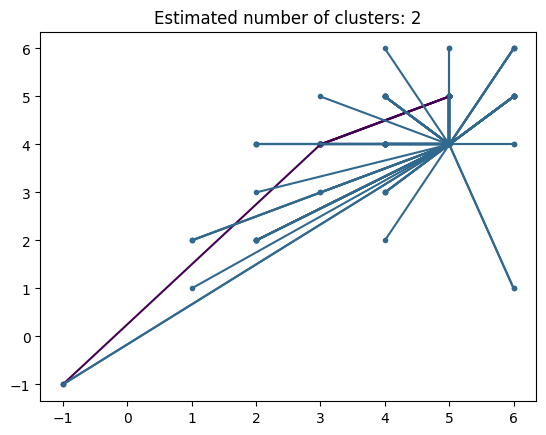

In [ ]:
#Visualizar resultado relación de atributos según el nº de clústeres estimados
plot_num_cluster (X3, n3_clusters_, labels3, cluster_centers_indices3)

In [ ]:
print('Estimated number of clusters: %d' % n3_clusters_)
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X3, labels3, metric='sqeuclidean'))

Estimated number of clusters: 2
Silhouette Coefficient: 0.768


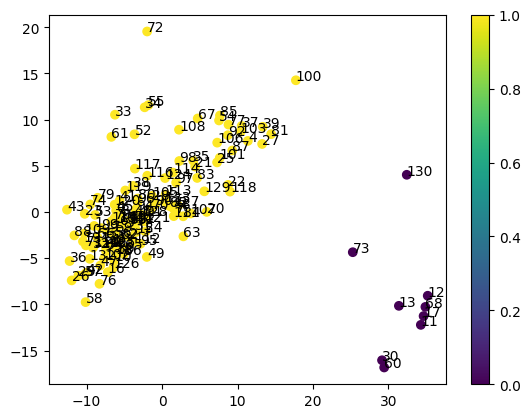

In [ ]:
#Visualizar gráfica de dispersión con la relación de atributos por clúster
plot_dispersion_etiquetas (X3, labels3)

In [ ]:
#Listar la relación de lso atributos más implicados para ser asociados a ese clúster
list_atributos_porCluster (data_processed3, n3_clusters_, labels3)

Cluster 1:
- Atributo n. 2: V2 (Media: 3.888888888888889)
- Atributo n. 4: SA1 (Media: 3.6666666666666665)
- Atributo n. 3: V3 (Media: 3.4444444444444446)
- Atributo n. 13: SF1 (Media: 3.111111111111111)
- Atributo n. 15: SF3 (Media: 3.2222222222222223)
Cluster 2:
- Atributo n. 1: V1 (Media: 4.290322580645161)
- Atributo n. 4: SA1 (Media: 4.298387096774194)
- Atributo n. 3: V3 (Media: 3.588709677419355)
- Atributo n. 13: SF1 (Media: 3.3306451612903225)
- Atributo n. 15: SF3 (Media: 3.4838709677419355)


In [ ]:
#Listar el valor medio del coeficiente Silhoutte por cluster
list_silhoutte_porCluster(data_processed3, labels3)

Índice de Silueta del Clúster 0: 0.5333770618501215
Índice de Silueta del Clúster 1: 0.5474114203819421


# **2. Ejecución para comparativa con algoritmos: Spectral Clustering y agrupación jerárquica**

Aunque hasta ahora hemos obtenido el número de clústeres a partir del mejor índice de silhoutte, a continuación queremos ver el modo de agrupación con el mismo número de clústeres que mejor resultado han dado los otros dos algoritmos.


## **2.1 Fichero completo**

In [ ]:
#Transformar datos categóricos a númericos
data_processed_21 = transformData(df_total)
#Crear una matriz de características (feature matrix) a partir de los datos y sus columnas
X_21, y_21 = data_processed_21.values, data_processed_21.columns

In [ ]:
#Obtener el valor apropiado para 'preferences' a partir del mejor coeficiente Silhoutte
ap_results_21 = eval_preferences(X_21)
#Obtener el valor apropiado para 'preferences' según un nº contcreto de clústeres
ap_results_21.loc[ap_results_21['clusters'].isin([6,7,8,9])]

,preference,clusters,sil_score
282,-1500.0,6.0,0.177532
283,-1450.0,6.0,0.177532
284,-1400.0,6.0,0.177532
285,-1350.0,6.0,0.177532
286,-1300.0,6.0,0.177532
287,-1250.0,6.0,0.177532
288,-1200.0,6.0,0.177532
289,-1150.0,6.0,0.177532
290,-1100.0,6.0,0.177532
291,-1050.0,6.0,0.177532


**Sin embargo, AffinityPropagation no agrupa con 7 clústeres con este dataset**

> ### **6 clusters**

In [ ]:
#Ejecución del algoritmo con los parámetros que obtienen un mejor coeficiente Silhoutte
ap_21_6 = AffinityPropagation(damping=0.70, preference=-1000, max_iter=200)
model_21_6 = ap_21_6.fit(X_21)
cluster_centers_indices_21_6 = model_21_6.cluster_centers_indices_
n_21_6_clusters_ = len(cluster_centers_indices_21_6)
labels_21_6 = model_21_6.predict(X_21)

In [ ]:
#Visualizar gráfica de dispersión con la relación de atributos por clúster
plot_dispersion_etiquetas (X_21, labels_21_6)

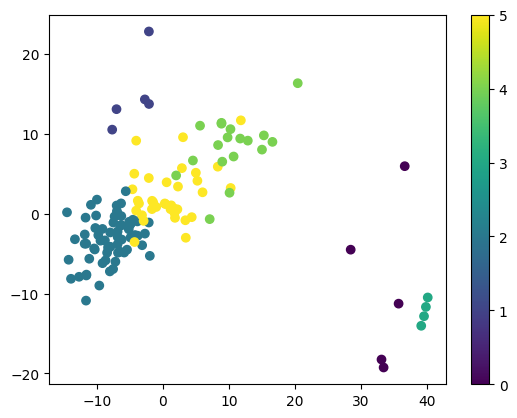

In [ ]:
#Visualizar gráfica de dispersión por clúster
plot_dispersion(X_21, labels_21_6)

In [ ]:
#Listar la relación de los atributos más implicados para ser asociados a ese clúster
list_atributos_porCluster (data_processed_21, n_21_6_clusters_, labels_21_6)

In [ ]:
#Listar el valor medio del coeficiente Silhoutte por cluster
list_silhoutte_porCluster(data_processed_21, labels_21_6)

Índice de Silueta del Clúster 0: 0.14024057195196502
Índice de Silueta del Clúster 1: 0.18575374108678336
Índice de Silueta del Clúster 2: 0.24963605104374884
Índice de Silueta del Clúster 3: 0.7501336545965835
Índice de Silueta del Clúster 4: 0.07211751991280052
Índice de Silueta del Clúster 5: 0.034491789275160736


> ### **8 clusters**

In [ ]:
#Ejecución del algoritmo con los parámetros que obtienen un mejor coeficiente Silhoutte
ap_21_8 = AffinityPropagation(damping=0.70, preference=-850, max_iter=200)
model_21_8 = ap_21_8.fit(X_21)
cluster_centers_indices_21_8 = model_21_8.cluster_centers_indices_
n_21_8_clusters_ = len(cluster_centers_indices_21_8)
labels_21_8 = model_21_8.predict(X_21)

In [ ]:
#Visualizar gráfica de dispersión con la relación de atributos por clúster
plot_dispersion_etiquetas (X_21, labels_21_8)

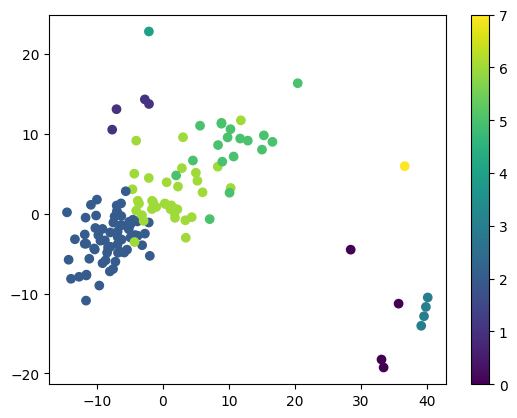

In [ ]:
#Visualizar gráfica de dispersión por clúster
plot_dispersion(X_21, labels_21_8)

In [ ]:
#Listar la relación de los atributos más implicados para ser asociados a ese clúster
list_atributos_porCluster (data_processed_21, n_21_8_clusters_, labels_21_8)

In [ ]:
#Listar el valor medio del coeficiente Silhoutte por cluster
list_silhoutte_porCluster(data_processed_21, labels_21_8)

Índice de Silueta del Clúster 0: 0.22110453367279703
Índice de Silueta del Clúster 1: 0.30221786658534955
Índice de Silueta del Clúster 2: 0.24963605104374884
Índice de Silueta del Clúster 3: 0.7333127005335314
Índice de Silueta del Clúster 4: 0.0
Índice de Silueta del Clúster 5: 0.06942364142162336
Índice de Silueta del Clúster 6: 0.032995133885525614
Índice de Silueta del Clúster 7: 0.0


> ### **9 clusters**

In [ ]:
#Ejecución del algoritmo con los parámetros que obtienen un mejor coeficiente Silhoutte
ap_21_9 = AffinityPropagation(damping=0.70, preference=-700, max_iter=200)
model_21_9 = ap_21_9.fit(X_21)
cluster_centers_indices_21_9 = model_21_9.cluster_centers_indices_
n_21_9_clusters_ = len(cluster_centers_indices_21_9)
labels_21_9 = model_21_9.predict(X_21)

In [ ]:
#Visualizar gráfica de dispersión con la relación de atributos por clúster
plot_dispersion_etiquetas (X_21, labels_21_9)

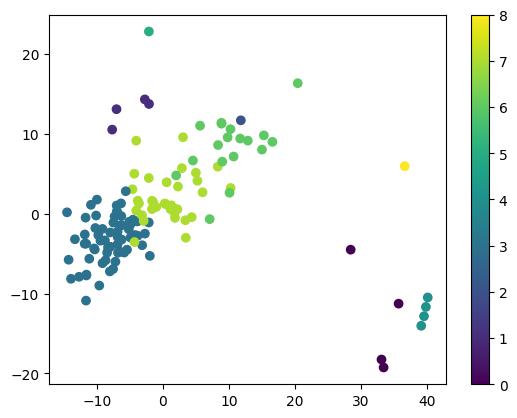

In [ ]:
#Visualizar gráfica de dispersión por clúster
plot_dispersion(X_21, labels_21_9)

In [ ]:
#Listar la relación de los atributos más implicados para ser asociados a ese clúster
list_atributos_porCluster(data_processed_21, n_21_9_clusters_, labels_21_9)

In [ ]:
#Listar el valor medio del coeficiente Silhoutte por cluster
list_silhoutte_porCluster(data_processed_21, labels_21_9)

Índice de Silueta del Clúster 0: 0.22110453367279703
Índice de Silueta del Clúster 1: 0.2968274159759808
Índice de Silueta del Clúster 2: 0.0
Índice de Silueta del Clúster 3: 0.2291468538719996
Índice de Silueta del Clúster 4: 0.7333127005335314
Índice de Silueta del Clúster 5: 0.0
Índice de Silueta del Clúster 6: 0.05950970517903355
Índice de Silueta del Clúster 7: 0.060284669020365424
Índice de Silueta del Clúster 8: 0.0


## **2.2 Fichero solo medias**

In [13]:
#Transformar datos categóricos a númericos
data_processed_22 = transformData(df_only_avg)
#Crear una matriz de características (feature matrix) a partir de los datos y sus columnas
X_22, y_22 = data_processed_22.values, data_processed_22.columns

In [14]:
#Obtener el valor apropiado para 'preferences' a partir del mejor coeficiente Silhoutte
ap_results_22 = eval_preferences(X_22)
#Obtener el valor apropiado para 'preferences' según un nº contcreto de clústeres
ap_results_22.loc[ap_results_22['clusters'].isin([4,5,6,7,8,9,10])]

,preference,clusters,sil_score
60,-400.0,4.0,0.346991
61,-350.0,5.0,0.347130
62,-300.0,6.0,0.136166
63,-250.0,6.0,0.136166
64,-200.0,8.0,0.115495
65,-150.0,10.0,0.123250


> ### **6 clusters**

In [ ]:
#Ejecución del algoritmo con los parámetros que obtienen un mejor coeficiente Silhoutte
ap_22_6 = AffinityPropagation(damping=0.70, preference=-300, max_iter=200)
model_22_6 = ap_22_6.fit(X_22)
cluster_centers_indices_22_6 = model_22_6.cluster_centers_indices_
n_22_6_clusters_ = len(cluster_centers_indices_22_6)
labels_22_6 = model_22_6.predict(X_22)

In [ ]:
#Visualizar gráfica de dispersión con la relación de atributos por clúster
plot_dispersion_etiquetas (X_22, labels_22_6)

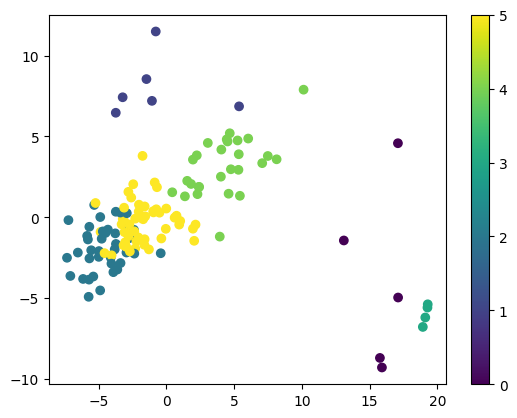

In [ ]:
#Visualizar gráfica de dispersión por clúster
plot_dispersion(X_22, labels_22_6)

In [ ]:
#Listar la relación de los atributos más implicados para ser asociados a ese clúster
list_atributos_porCluster (data_processed_22, n_22_6_clusters_, labels_22_6)

In [ ]:
#Listar el valor medio del coeficiente Silhoutte por cluster
list_silhoutte_porCluster(data_processed_22, labels_22_6)

Índice de Silueta del Clúster 0: 0.13769891122173228
Índice de Silueta del Clúster 1: 0.13158620610444763
Índice de Silueta del Clúster 2: 0.1633081191856601
Índice de Silueta del Clúster 3: 0.7707502944373661
Índice de Silueta del Clúster 4: 0.15647050718788605
Índice de Silueta del Clúster 5: 0.05474482366362679


> ### **8 clusters**

In [ ]:
#Ejecución del algoritmo con los parámetros que obtienen un mejor coeficiente Silhoutte
ap_22_8 = AffinityPropagation(damping=0.70, preference=-200, max_iter=200)
model_22_8 = ap_22_8.fit(X_22)
cluster_centers_indices_22_8 = model_22_8.cluster_centers_indices_
n_22_8_clusters_ = len(cluster_centers_indices_22_8)
labels_22_8 = model_22_8.predict(X_22)

In [ ]:
#Visualizar gráfica de dispersión con la relación de atributos por clúster
plot_dispersion_etiquetas (X_22, labels_22_8)

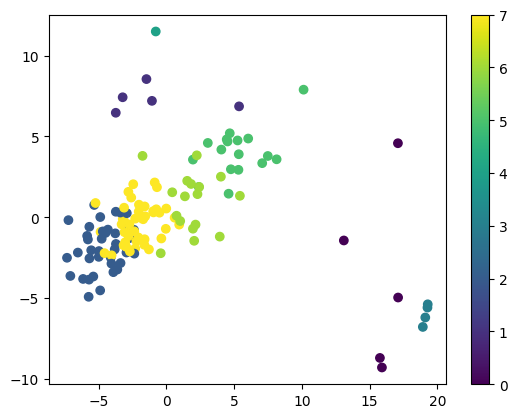

In [ ]:
#Visualizar gráfica de dispersión por clúster
plot_dispersion(X_22, labels_22_8)

In [ ]:
#Listar la relación de los atributos más implicados para ser asociados a ese clúster
list_atributos_porCluster (data_processed_22, n_22_8_clusters_, labels_22_8)

In [ ]:
#Listar el valor medio del coeficiente Silhoutte por cluster
list_silhoutte_porCluster(data_processed_22, labels_22_8)

Índice de Silueta del Clúster 0: 0.13492030779583586
Índice de Silueta del Clúster 1: 0.22805634832233426
Índice de Silueta del Clúster 2: 0.1522925392851702
Índice de Silueta del Clúster 3: 0.7707502944373661
Índice de Silueta del Clúster 4: 0.0
Índice de Silueta del Clúster 5: 0.13655182551529063
Índice de Silueta del Clúster 6: 0.024237303702591126
Índice de Silueta del Clúster 7: 0.04013378719987782


> ### **10 clusters**

In [ ]:
#Ejecución del algoritmo con los parámetros que obtienen un mejor coeficiente Silhoutte
ap_22_10 = AffinityPropagation(damping=0.70, preference=-150, max_iter=200)
model_22_10 = ap_22_10.fit(X_22)
cluster_centers_indices_22_10 = model_22_10.cluster_centers_indices_
n_22_10_clusters_ = len(cluster_centers_indices_22_10)
labels_22_10 = model_22_10.predict(X_22)

In [ ]:
#Visualizar gráfica de dispersión con la relación de atributos por clúster
plot_dispersion_etiquetas (X_22, labels_22_10)

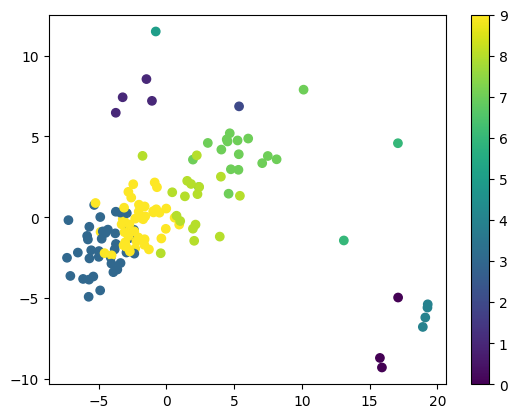

In [ ]:
#Visualizar gráfica de dispersión por clúster
plot_dispersion(X_22, labels_22_10)

In [ ]:
#Listar la relación de los atributos más implicados para ser asociados a ese clúster
list_atributos_porCluster (data_processed_22, n_22_10_clusters_, labels_22_10)

In [ ]:
#Listar el valor medio del coeficiente Silhoutte por cluster
list_silhoutte_porCluster(data_processed_22, labels_22_10)

Índice de Silueta del Clúster 0: 0.5070470307144469
Índice de Silueta del Clúster 1: 0.34327855658806655
Índice de Silueta del Clúster 2: 0.0
Índice de Silueta del Clúster 3: 0.1522925392851702
Índice de Silueta del Clúster 4: 0.7188601257873226
Índice de Silueta del Clúster 5: 0.0
Índice de Silueta del Clúster 6: 0.10471881079484023
Índice de Silueta del Clúster 7: 0.13362414727159933
Índice de Silueta del Clúster 8: 0.024237303702591126
Índice de Silueta del Clúster 9: 0.04013378719987782


## **2.3 Fichero sin medias**

In [ ]:
#Transformar datos categóricos a númericos
data_processed_23 = transformData(df_without_avg)
#Crear una matriz de características (feature matrix) a partir de los datos y sus columnas
X_23, y_23 = data_processed_23.values, data_processed_23.columns

In [ ]:
#Obtener el valor apropiado para 'preferences' a partir del mejor coeficiente Silhoutte
ap_results_23 = eval_preferences(X_23)
#Obtener el valor apropiado para 'preferences' según un nº contcreto de clústeres
ap_results_23.loc[ap_results_23['clusters'].isin([5,6,7,8,9,10])]

,preference,clusters,sil_score
228,-1250.0,5.0,0.177931
229,-1200.0,5.0,0.177931
230,-1150.0,5.0,0.177931
231,-1100.0,6.0,0.174924
232,-1050.0,6.0,0.174924
233,-1000.0,6.0,0.174924
234,-950.0,6.0,0.174924
235,-900.0,6.0,0.174924
236,-850.0,6.0,0.174924
237,-800.0,6.0,0.174924


> ### **6 clusters**

In [ ]:
#Ejecución del algoritmo con los parámetros que obtienen un mejor coeficiente Silhoutte
ap_23_6 = AffinityPropagation(damping=0.70, preference=-800, max_iter=200)
model_23_6 = ap_23_6.fit(X_23)
cluster_centers_indices_23_6 = model_23_6.cluster_centers_indices_
n_23_6_clusters_ = len(cluster_centers_indices_23_6)
labels_23_6 = model_23_6.predict(X_23)

In [ ]:
#Visualizar gráfica de dispersión con la relación de atributos por clúster
plot_dispersion_etiquetas (X_23, labels_23_6)

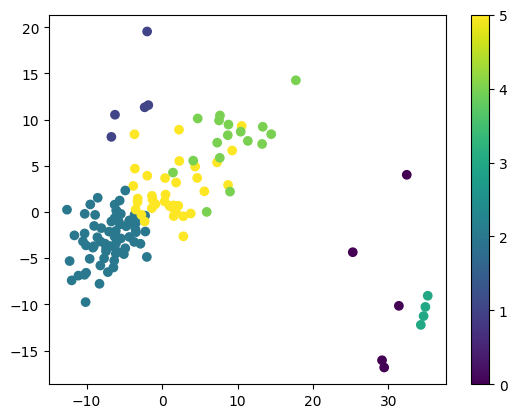

In [ ]:
#Visualizar gráfica de dispersión por clúster
plot_dispersion(X_23, labels_23_6)

In [ ]:
#Listar la relación de los atributos más implicados para ser asociados a ese clúster
list_atributos_porCluster (data_processed_23, n_23_6_clusters_, labels_23_6)

Cluster 1:
- Atributo n. 4: SA1 (Media: 3.2)
- Atributo n. 2: V2 (Media: 3.4)
- Atributo n. 5: SA2 (Media: 3.0)
- Atributo n. 3: V3 (Media: 2.6)
- Atributo n. 13: SF1 (Media: 2.4)
Cluster 2:
- Atributo n. 1: V1 (Media: 3.8)
- Atributo n. 2: V2 (Media: 3.8)
- Atributo n. 4: SA1 (Media: -1.0)
- Atributo n. 3: V3 (Media: 3.4)
- Atributo n. 15: SF3 (Media: -1.0)
Cluster 3:
- Atributo n. 1: V1 (Media: 4.8059701492537314)
- Atributo n. 4: SA1 (Media: 5.164179104477612)
- Atributo n. 3: V3 (Media: 4.17910447761194)
- Atributo n. 2: V2 (Media: 4.731343283582089)
- Atributo n. 13: SF1 (Media: 4.447761194029851)
Cluster 4:
- Atributo n. 2: V2 (Media: 4.5)
- Atributo n. 3: V3 (Media: 4.5)
- Atributo n. 1: V1 (Media: 4.5)
- Atributo n. 15: SF3 (Media: 4.0)
- Atributo n. 13: SF1 (Media: 4.0)
Cluster 5:
- Atributo n. 1: V1 (Media: 3.1176470588235294)
- Atributo n. 3: V3 (Media: 2.176470588235294)
- Atributo n. 4: SA1 (Media: 2.4705882352941178)
- Atributo n. 2: V2 (Media: 3.0588235294117645)
- Atrib

In [ ]:
#Listar el valor medio del coeficiente Silhoutte por cluster
list_silhoutte_porCluster(data_processed_23, labels_23_6)

Índice de Silueta del Clúster 0: 0.13401015985697776
Índice de Silueta del Clúster 1: 0.1753607522648051
Índice de Silueta del Clúster 2: 0.24823138112918428
Índice de Silueta del Clúster 3: 0.7282433642242887
Índice de Silueta del Clúster 4: 0.05858701818353923
Índice de Silueta del Clúster 5: 0.03364390371238399


> ### **8 clusters**

In [ ]:
#Ejecución del algoritmo con los parámetros que obtienen un mejor coeficiente Silhoutte
ap_23_8 = AffinityPropagation(damping=0.70, preference=-650, max_iter=200)
model_23_8 = ap_23_8.fit(X_23)
cluster_centers_indices_23_8 = model_23_8.cluster_centers_indices_
n_23_8_clusters_ = len(cluster_centers_indices_23_8)
labels_23_8 = model_23_8.predict(X_23)

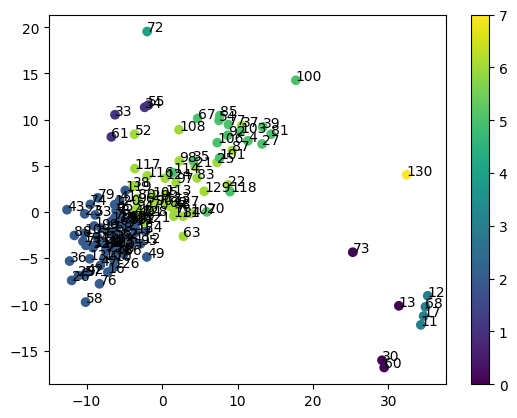

In [ ]:
#Visualizar gráfica de dispersión con la relación de atributos por clúster
plot_dispersion_etiquetas (X_23, labels_23_8)

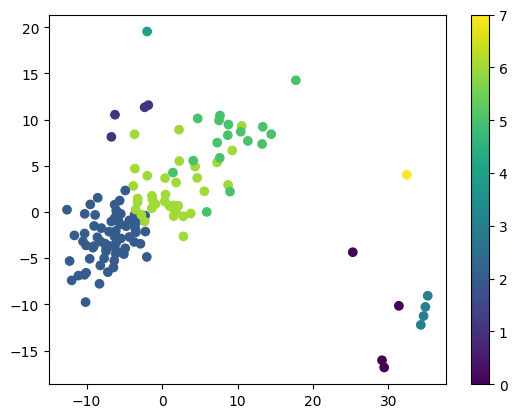

In [ ]:
#Visualizar gráfica de dispersión por clúster
plot_dispersion(X_23, labels_23_8)

In [ ]:
#Listar la relación de los atributos más implicados para ser asociados a ese clúster
list_atributos_porCluster (data_processed_23, n_23_8_clusters_, labels_23_8)

Cluster 1:
- Atributo n. 4: SA1 (Media: 4.25)
- Atributo n. 2: V2 (Media: 4.5)
- Atributo n. 3: V3 (Media: 3.5)
- Atributo n. 15: SF3 (Media: 3.5)
- Atributo n. 13: SF1 (Media: 3.25)
Cluster 2:
- Atributo n. 1: V1 (Media: 5.0)
- Atributo n. 2: V2 (Media: 5.0)
- Atributo n. 4: SA1 (Media: -1.0)
- Atributo n. 3: V3 (Media: 4.5)
- Atributo n. 15: SF3 (Media: -1.0)
Cluster 3:
- Atributo n. 1: V1 (Media: 4.8059701492537314)
- Atributo n. 4: SA1 (Media: 5.164179104477612)
- Atributo n. 3: V3 (Media: 4.17910447761194)
- Atributo n. 2: V2 (Media: 4.731343283582089)
- Atributo n. 13: SF1 (Media: 4.447761194029851)
Cluster 4:
- Atributo n. 2: V2 (Media: 4.5)
- Atributo n. 3: V3 (Media: 4.5)
- Atributo n. 1: V1 (Media: 4.5)
- Atributo n. 15: SF3 (Media: 4.0)
- Atributo n. 13: SF1 (Media: 4.0)
Cluster 5:
- Atributo n. 1: V1 (Media: -1.0)
- Atributo n. 2: V2 (Media: -1.0)
- Atributo n. 4: SA1 (Media: -1.0)
- Atributo n. 6: SA3 (Media: -1.0)
- Atributo n. 3: V3 (Media: -1.0)
Cluster 6:
- Atributo n.

In [ ]:
#Listar el valor medio del coeficiente Silhoutte por cluster
list_silhoutte_porCluster(data_processed_23, labels_23_8)

Índice de Silueta del Clúster 0: 0.22180637534896158
Índice de Silueta del Clúster 1: 0.27767146551948296
Índice de Silueta del Clúster 2: 0.24823138112918428
Índice de Silueta del Clúster 3: 0.7111163984217795
Índice de Silueta del Clúster 4: 0.0
Índice de Silueta del Clúster 5: 0.057362411855498216
Índice de Silueta del Clúster 6: 0.03240134421759301
Índice de Silueta del Clúster 7: 0.0


> ### **10 clusters**

In [ ]:
#Ejecución del algoritmo con los parámetros que obtienen un mejor coeficiente Silhoutte
ap_23_10 = AffinityPropagation(damping=0.70, preference=-500, max_iter=200)
model_23_10 = ap_23_10.fit(X_23)
cluster_centers_indices_23_10 = model_23_10.cluster_centers_indices_
n_23_10_clusters_ = len(cluster_centers_indices_23_10)
labels_23_10 = model_23_10.predict(X_23)

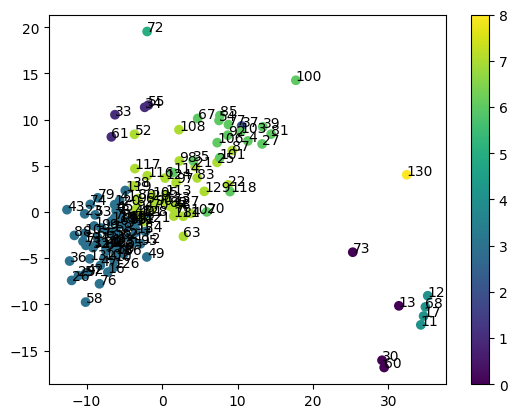

In [ ]:
#Visualizar gráfica de dispersión con la relación de atributos por clúster
plot_dispersion_etiquetas (X_23, labels_23_10)

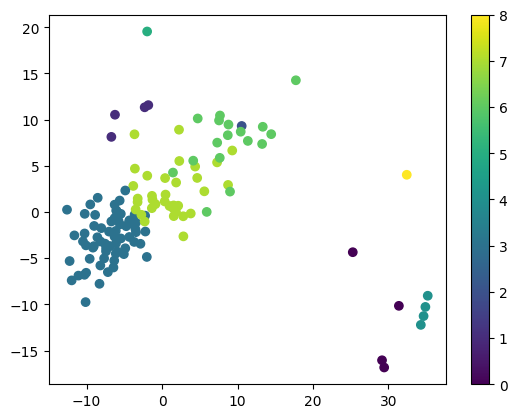

In [ ]:
#Visualizar gráfica de dispersión por clúster
plot_dispersion(X_23, labels_23_10)

In [ ]:
#Listar la relación de los atributos más implicados para ser asociados a ese clúster
list_atributos_porCluster (data_processed_23, n_23_10_clusters_, labels_23_10)

Cluster 1:
- Atributo n. 4: SA1 (Media: 4.25)
- Atributo n. 2: V2 (Media: 4.5)
- Atributo n. 3: V3 (Media: 3.5)
- Atributo n. 15: SF3 (Media: 3.5)
- Atributo n. 13: SF1 (Media: 3.25)
Cluster 2:
- Atributo n. 1: V1 (Media: 5.0)
- Atributo n. 2: V2 (Media: 5.0)
- Atributo n. 4: SA1 (Media: -1.0)
- Atributo n. 3: V3 (Media: 4.5)
- Atributo n. 15: SF3 (Media: -1.0)
Cluster 3:
- Atributo n. 1: V1 (Media: 4.0)
- Atributo n. 4: SA1 (Media: -1.0)
- Atributo n. 10: SP1 (Media: -1.0)
- Atributo n. 7: SI0 (Media: -1.0)
- Atributo n. 2: V2 (Media: 4.0)
Cluster 4:
- Atributo n. 1: V1 (Media: 4.8059701492537314)
- Atributo n. 4: SA1 (Media: 5.164179104477612)
- Atributo n. 3: V3 (Media: 4.17910447761194)
- Atributo n. 2: V2 (Media: 4.731343283582089)
- Atributo n. 13: SF1 (Media: 4.447761194029851)
Cluster 5:
- Atributo n. 2: V2 (Media: 4.5)
- Atributo n. 3: V3 (Media: 4.5)
- Atributo n. 1: V1 (Media: 4.5)
- Atributo n. 15: SF3 (Media: 4.0)
- Atributo n. 13: SF1 (Media: 4.0)
Cluster 6:
- Atributo n.

In [ ]:
#Listar el valor medio del coeficiente Silhoutte por cluster
list_silhoutte_porCluster(data_processed_23, labels_23_10)

Índice de Silueta del Clúster 0: 0.22180637534896158
Índice de Silueta del Clúster 1: 0.27483502600966503
Índice de Silueta del Clúster 2: 0.0
Índice de Silueta del Clúster 3: 0.2294491555589476
Índice de Silueta del Clúster 4: 0.7111163984217795
Índice de Silueta del Clúster 5: 0.0
Índice de Silueta del Clúster 6: 0.047416096242266025
Índice de Silueta del Clúster 7: 0.05759925551282663
Índice de Silueta del Clúster 8: 0.0
